In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
import pandas as pd
import matplotlib.ticker as ticker
from scipy import spatial

'''
Code to read satellite GOES data foe the period 2/3 feb 2022 and produce a
unique dataset with variables SST skin with assigned lat/lon values
Note that SST is reported over all water pixels, and only data with quality flag DQF=0 should be used to select clear-sky pixels.
'''

dict_plot_settings = {
    'labelsize'    :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


In [2]:
def goes16_earth_coordinates(x,y):
    """
    From the GOES16 fixed grid to the Earth coordinates in degrees.
    """
    req = 6378137 # m
    rpol = 6356752.31414 # m
    H = 42164160 # m
    lambda0 = -1.308996939 # rad

    a = np.sin(x)**2+np.cos(x)**2*(np.cos(y)**2+req**2*np.sin(y)**2/rpol**2) 
    b = -2*H*np.cos(x)*np.cos(y)
    c = H**2-req**2

    rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)

    sx = rs*np.cos(x)*np.cos(y)
    sy = -rs*np.sin(x)
    sz = rs*np.cos(x)*np.sin(y)

    lat = np.arctan(req**2*sz/(rpol**2*np.sqrt((H-sx)**2+sy**2)))
    lon = lambda0-np.arctan(sy/(H-sx))

    return lon*180/np.pi, lat*180/np.pi


def crop_field(field,lon,lat,area):
    """
    Function to crop a 2d field over the area specified by the list
    area = [minlon,maxlon,minlat,maxlat]
    """
    valid_indices = np.argwhere((lon>area[0])&(lon<area[1])&(lat>area[2])&(lat<area[3]))
    x_min, y_min = valid_indices.min(axis=0)
    x_max, y_max = valid_indices.max(axis=0)
    return field[x_min:x_max+1, y_min:y_max+1]

In [9]:
# reading goes data
flag_plot = 0
#path2GOES = '/home/agostino/SST-impact_data/'
path2GOES = '/Volumes/PortableSSD/GOES_data/skin_T/'
filelist = np.sort(glob.glob(path2GOES+'*.nc'))
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_goes_quicklooks/'
# defining box of interest for extracting the data
minlon = -55.5; maxlon = -52.; minlat = 5.5; maxlat = 8.5; 
extent_param = [minlon, maxlon, minlat, maxlat]

# reading tsg from merian to extract lat/lon of the ship for the 2 days
tsg_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc'
tsg = xr.open_dataset(tsg_file)

sst_goes = []
for ind_file, filename in enumerate(filelist):
    
    # reading one file
    #filename = 'OR_ABI-L2-SSTF-M6_G16_s20200320000144_e20200320059452_c20200320106148.nc'
    ds = xr.open_dataset(filename)


    # extract time interval of the goes file
    dd =  pd.to_datetime(ds.t.values).day
    hh =  pd.to_datetime(ds.t.values).hour
    time_start = datetime(2020,2,dd,hh,0,0)
    if hh == 23:
        time_end =  datetime(2020,2,dd,hh,59,59)
    else:
        time_end =  datetime(2020,2,dd,hh+1,0,0)
    if len(str(hh)) == 1:
        date = '2020020'+str(dd)+'_0'+str(hh)
    else:
        date = '2020020'+str(dd)+'_'+str(hh)

    print('processing date:'+date)
    # select time slice of tsg data corresponding to goes file selected
    tsg_slice = tsg.sel(TIME=slice(time_start, time_end))

    # converting goes fixed grid to Earth coordinates in degrees.
    x = ds.x.values
    y = ds.y.values
    xx, yy = np.meshgrid(x,y)
    lon, lat = goes16_earth_coordinates(xx,yy)


    # cropping the sst and sst_flag fields to the eurec4a box of interest
    sst = ds.SST.values
    dqf = ds.DQF.values
    sst_crop = crop_field(sst,lon,lat,extent_param)
    lon_crop = crop_field(lon,lon,lat,extent_param)
    lat_crop = crop_field(lat,lon,lat,extent_param)
    dqf_crop = crop_field(dqf,lon,lat,extent_param)

    
    # Select only values that are == 0 in the original DQF field.
    dqf_mask = dqf_crop+1 
    # setting to nans all flag is non zero
    dqf_mask[dqf_mask!=1]=np.nan
    sst_crop[dqf_mask!=1]=np.nan

    # selecting closest lat/lon points of satellite data to the ship trajectory
    # Create a KDTree object based on the grid
    tree = spatial.KDTree(list(zip(lon_crop.ravel(), lat_crop.ravel())))

    # Define the lat/lon points of the ship position we wish to find the nearest neighbor for
    pt_list = []
    for ind_point in range(len(tsg_slice.LONGITUDE.values)):
        pt_list.append([tsg_slice.LONGITUDE.values[ind_point], tsg_slice.LATITUDE.values[ind_point]])

    pts = np.array(pt_list)

    # Query the points in the KDTree. Output is 
    # 1) distance of point to the nearest grid neighbor
    # 2) index of neighbor point in the tree.
    dist_to_neighbor, idx_neighbor = tree.query(pts)

    #for point, dist, idx in zip(pts, dist_to_neighbor, idx_neighbor):
    #    print('The point %s is nearest the grid location %s and is %.2f units away.' \
    #          % (point, tree.data[idx], dist))

    # selecting sst corresponding to the nearest neighbor
    sst_goes.append(sst_crop.flat[idx_neighbor])
    
    
    # producing quicklook to check the data matching
    if flag_plot ==1:
        fig, axs = plt.subplots(1,1, figsize=(24,10), constrained_layout=True)
        labelsizeaxes   = dict_plot_settings['labelsizeaxes']
        fontSizeTitle   = dict_plot_settings['fontSizeTitle']
        fontSizeX       = dict_plot_settings['fontSizeX']
        fontSizeY       = dict_plot_settings['fontSizeY']
        cbarAspect      = dict_plot_settings['cbarAspect']
        fontSizeCbar    = dict_plot_settings['fontSizeCbar']
        rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
        matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
        plt.rcParams.update({'font.size':dict_plot_settings['font_size']})    
        #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)

        axs.spines["top"].set_visible(False)
        axs.spines["right"].set_visible(False)
        axs.spines["bottom"].set_linewidth(3)
        axs.spines["left"].set_linewidth(3)
        axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        axs.tick_params(which='minor', length=5, width=2)
        axs.tick_params(which='major', length=7, width=3)
        axs.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        axs.tick_params(axis='both', labelsize=32)

        sst_vmin = 26.; sst_vmax = 28.

        plt.pcolormesh(lon_crop,lat_crop,(sst_crop-273.15)*dqf_mask,shading='nearest',vmin=sst_vmin,vmax=sst_vmax)

        pc = plt.scatter(lon_crop[dqf_crop==0],lat_crop[dqf_crop==0],c=sst_crop[dqf_crop==0]-273.15,marker='.',
                        vmin=sst_vmin,vmax=sst_vmax)

        msm = plt.scatter(tsg_slice.LONGITUDE.values, tsg_slice.LATITUDE.values, color='black')
        plt.scatter(tree.data[idx_neighbor][:,0], tree.data[idx_neighbor][:,1], facecolor='none', edgecolors='k', s=100)
        plt.colorbar(pc)
        plt.title(ds.t.values)
        fig.savefig(path_out_plots+date+'_quicklooks_goes.png', format='png')

sst_goes_arr = np.concatenate(sst_goes)

processing date:20200202_00


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_01


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_02


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_03


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_04


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_05


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_06


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_07


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_08


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_09


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_10


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_11


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_12


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_13


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_14


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_15


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_16


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_17


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_18


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_19


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_20


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_21


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_22


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200202_23


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_00


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_01


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_02


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_03


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_04


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_05


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_06


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_07


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_08


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_09


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_10


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_11


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_12


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_13


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_14


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_15


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_16


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_17


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_18


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_19


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_20


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_21


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_22


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


processing date:20200203_23


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_10111/3622915893.py:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


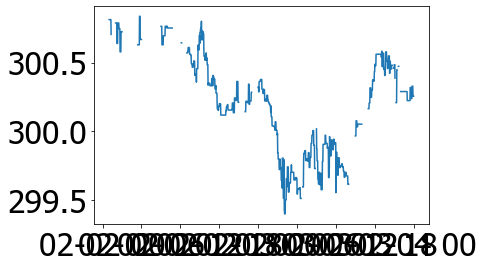

In [13]:
tsg_case = tsg.sel(TIME=slice(datetime(2020,2,2,0,0,0), datetime(2020,2,3,23,59,59)))
plt.plot(tsg_case.TIME.values, sst_goes_arr)

# storing data in xarray dataset
dim_sst           = ['time']
coords         = {"time":tsg_case.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_goes_arr,
                 attrs={'long_name':'sea surface skin temperature from GOES-R',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)
SST_DS.to_netcdf(path_out_plots+'SST_goes_merian.nc')


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

Text(0.5, 1.0, '2020-02-02T00:29:59.215728000')

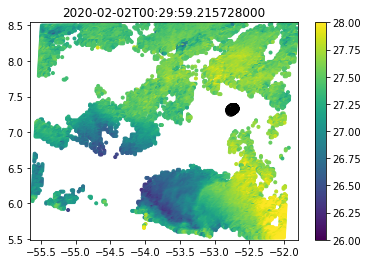

In [69]:
np.meshgrid(tsg_slice.LONGITUDE.values[0], tsg_slice.LATITUDE.values[0])

[array([[-52.73038]]), array([[7.32908]])]

In [33]:
# Test points
x = -0.024052 #ds.x.values
y = 0.095340 #ds.y.values

# Compute the lon-lat coordinates.
req = 6378137 # m
rpol = 6356752.31414 # m
H = 42164160 # m
lambda0 = -1.308996939 # rad

a = np.sin(x)**2+np.cos(x)**2*(np.cos(y)**2+req**2*np.sin(y)**2/rpol**2) 
b = -2*H*np.cos(x)*np.cos(y)
c = H**2-req**2

rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)

sx = rs*np.cos(x)*np.cos(y)
sy = -rs*np.sin(x)
sz = rs*np.cos(x)*np.sin(y)

lat = np.arctan(req**2*sz/(rpol**2*np.sqrt((H-sx)**2+sy**2)))
lon = lambda0-np.arctan(sy/(H-sx))
print(lon*180/np.pi)
print(lat*180/np.pi)

-84.69093211900741
33.84616229060915


In [32]:
print(a)
print(b)
print(c)
print(rs)
print(sx)
print(sy)
print(sz)

1.0000610393966292
-83921070.03211282
1737135756914831
37116295.874486506
36937048.733040124
892635.0778582101
3532287.212730611


In [37]:
lon,lat = goes16_earth_coordinates(-0.024052,0.095340)
print(lon)
print(lat)

-84.69093211900741
33.84616229060915


In [71]:
myList = np.asarray([[0.145, 10], [0.156, 15], [0.254, 28], [0.322, 35], [0.421, 55]])
myList

array([[ 0.145, 10.   ],
       [ 0.156, 15.   ],
       [ 0.254, 28.   ],
       [ 0.322, 35.   ],
       [ 0.421, 55.   ]])

In [72]:
np.shape(myList)

(5, 2)

In [74]:
# Make a 2D grid
x, y = np.mgrid[0:40:5, 0:80:10]
print(x)

[[ 0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  5  5  5]
 [10 10 10 10 10 10 10 10]
 [15 15 15 15 15 15 15 15]
 [20 20 20 20 20 20 20 20]
 [25 25 25 25 25 25 25 25]
 [30 30 30 30 30 30 30 30]
 [35 35 35 35 35 35 35 35]]


In [75]:
print(y)

[[ 0 10 20 30 40 50 60 70]
 [ 0 10 20 30 40 50 60 70]
 [ 0 10 20 30 40 50 60 70]
 [ 0 10 20 30 40 50 60 70]
 [ 0 10 20 30 40 50 60 70]
 [ 0 10 20 30 40 50 60 70]
 [ 0 10 20 30 40 50 60 70]
 [ 0 10 20 30 40 50 60 70]]


The point [7 7] is nearest the grid location [ 5. 10.] and is 3.61 units away.
The point [25 35] is nearest the grid location [25. 30.] and is 5.00 units away.
The point [30 30] is nearest the grid location [30. 30.] and is 0.00 units away.


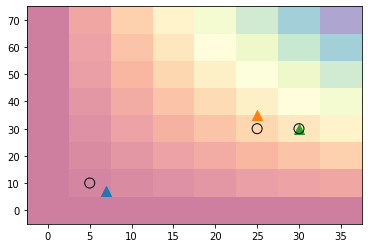

In [82]:
# Create a KDTree object based on the grid
tree = spatial.KDTree(list(zip(x.ravel(), y.ravel())))

# Specify a set of points you wish to find the nearest neighbor for
pts = np.array([[7, 7], [25, 35], [30,30]])


# Query the points in the KDTree. Output is 
# 1) distance of point to the nearest grid neighbor
# 2) index of neighbor point in the tree.
dist_to_neighbor, idx_neighbor = tree.query(pts)


for point, dist, idx in zip(pts, dist_to_neighbor, idx_neighbor):
    print('The point %s is nearest the grid location %s and is %.2f units away.' \
          % (point, tree.data[idx], dist))
    
    
plt.pcolormesh(x, y, x*y, cmap="Spectral", alpha=.5)
for i in pts:
    plt.scatter(i[0], i[1], marker='^', s=100)

plt.scatter(tree.data[idx_neighbor][:,0], tree.data[idx_neighbor][:,1], facecolor='none', edgecolors='k', s=100)